In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [36]:
#median = 5
#std_deviation = 2.5
Ndata = 1000

data = np.concatenate([np.ones(Ndata//2),-np.ones(Ndata//2)])

<BarContainer object of 20 artists>

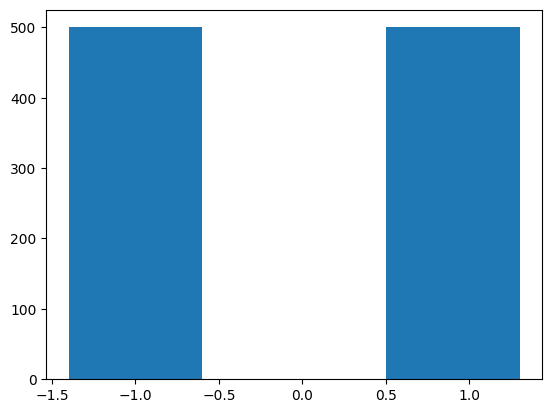

In [37]:
hist, bins_ = np.histogram(data,bins=20)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist)

In [38]:
def linear_beta_schedule(steps, start=0.0001, end=0.02):
    return np.linspace(start, end, steps)

def alpha_normaliced(step):
    return np.prod(linear_beta_schedule(step))

def forward_process(data):

  noised_data = np.zeros(len(data))
  noise = np.zeros(len(data))

  for i in range(len(data)):

    time = np.random.randint(1000)
    noise[i] = np.random.normal(0,1)
    alpha = alpha_normaliced(time)
    noised_data[i] = data[i] * np.sqrt(alpha) + noise[i] * np.sqrt(1-alpha)

    return noised_data, noise

In [33]:
noised_data, noise = forward_process(data)

<BarContainer object of 200 artists>

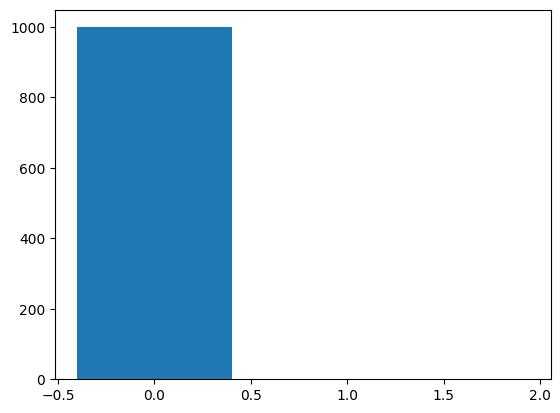

In [34]:
hist, bins_ = np.histogram(noised_data,bins=200)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def create_dataloader(data,target):

  data_tensor = torch.tensor(data, dtype=torch.float32).reshape(-1,1)
  target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1,1)

  data_ds = TensorDataset(data_tensor,target_tensor)
  data_dl = DataLoader(data_ds, batch_size=50, shuffle=True)

  return data_dl

def preprocessing(data, target):

  train_data_, test_data, train_target_, test_target = train_test_split(data, target, test_size=0.2)

  train_data, valid_data, train_target, valid_target = train_test_split(train_data_, train_target_, test_size=0.2)

  train_dl = create_dataloader(train_data, train_target)
  valid_dl = create_dataloader(valid_data, valid_target)
  test_dl = create_dataloader(test_data, test_target)

  return train_dl, valid_dl, test_dl


In [8]:
import torch.nn as nn

class Feed_forward(nn.Module):

  def __init__(self, input_size, output_size,n_hidden_layers,depht):
    super().__init__()

    #Setting input and output layers
    l = [0] * (2*n_hidden_layers + 2)
    l[0] = nn.Linear(input_size,depht)
    l[-1] = nn.Linear(depht,output_size)

    #Assembling hidden layers
    i = 1
    while i <= n_hidden_layers:
      l[i] = nn.Linear(depht,depht)
      l[i+1] = nn.ReLU()
      i+=2
    #    try:
    self.model_list = nn.ModuleList(l)

#        except:
#         print(l)

  def forward(self,x):
    for layer in self.model_list:
      x = layer(x)
    return x


In [19]:
def train(model,num_epochs,train_dl,valid_dl):

    loss_hist_train = np.zeros(num_epochs)
    loss_hist_valid = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        for x_batch, y_batch in train_dl:

          pred = model(x_batch)
          #Define loss function
          loss = loss_fn(pred, y_batch)
          #Backpropagation
          loss.backward()
          #Apply gradient to the weights
          optimizer.step()
          #Make gradients zero
          optimizer.zero_grad()
          loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        for x_batch, y_batch in valid_dl:

          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)

          loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)

    return loss_hist_train, loss_hist_valid

In [14]:
model = Feed_forward(input_size=1,output_size=1,n_hidden_layers=1,depht=20)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()

In [12]:
train_dl, valid_dl, test_dl = preprocessing(noised_data,noise)

In [20]:
loss_hist_train,loss_hist_valid = train(model=model, num_epochs=100, train_dl=train_dl, valid_dl=valid_dl)

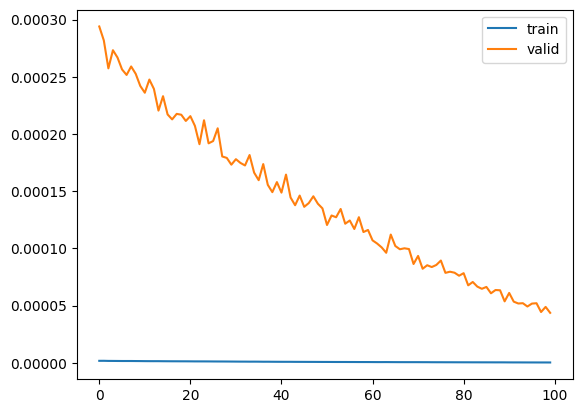

In [21]:
plt.plot(loss_hist_train,label='train')
plt.plot(loss_hist_valid,label='valid')
plt.legend()

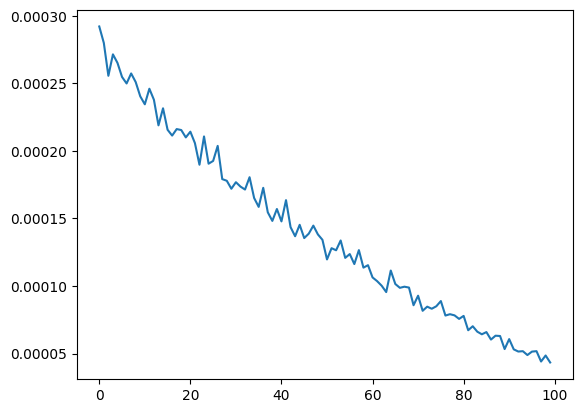

In [22]:
plt.plot(abs(loss_hist_train-loss_hist_valid))

array([1.04019279, 0.26362578, 0.84105933, 0.71330661, 1.68007448,
       1.83023956, 0.7727433 , 1.57986068, 1.48493806, 1.7085144 ])